# **Streaming Music Popularity Prediction based on Multidimensional Music Features**
=================
DS-1007 Final Class Project
-----------------

The main purpose for this project is to produce business insight for recording companies. Based on a 2021 Spotify music data, we first want to understand the dataset a bit more before we build a ML model. Thus, we start with a first-round data pre-processing. Later on as we dig deeper into this dataset, we noticed several defauls that might lead to significant bias when building a model, therefore we kept cleaning and processing the dataset while EDA.

## **First Round Data Preprocessing**

In [49]:
import io
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [50]:
# Load in data
df = pd.read_csv('spotify_songs_team_one.csv')

In [51]:
df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [52]:
# display all the column names
df.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')

Because the goal of this analysis is to look into song's features to make prediction on its popularity, columns like track_id, track_name, track_artist, track_album_id, track_album_name, playlist_id are irrelvants ones.

In [53]:
# specify columns needed to be removed
column_to_remove = ['track_id', 'track_name', 'track_artist', 'track_album_id', 'track_album_name', 'playlist_id']
df = df.drop(columns = column_to_remove)

In [54]:
# Notice that some data in the column 'track_album_release_date' is missing the exact streaming month,
# we want to mark these months as NaN instead of automatically assigning Jan 1 (as the function pd.to_datetime generally does)

df['month'] = np.where(df['track_album_release_date'].str.len() < 7, np.nan, pd.to_datetime(df['track_album_release_date'], errors='coerce').dt.month)
df['track_album_release_date'] = pd.to_datetime(df['track_album_release_date'], errors='coerce')
df['year'] = df['track_album_release_date'].dt.year

# Calculate decade and deal with NaN values
df['decade'] = (df['year'] // 10 * 10).astype(str) + 's'
df.loc[df['year'].isna(), 'decade'] = 'NaN'

In [55]:
df.head()

,track_popularity,track_album_release_date,playlist_name,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,month,year,decade
0,66,2019-06-14,Pop Remix,pop,dance pop,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754,6.0,2019.0,2010.0s
1,67,2019-12-13,Pop Remix,pop,dance pop,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600,12.0,2019.0,2010.0s
2,70,2019-07-05,Pop Remix,pop,dance pop,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616,7.0,2019.0,2010.0s
3,60,2019-07-19,Pop Remix,pop,dance pop,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093,7.0,2019.0,2010.0s
4,69,2019-03-05,Pop Remix,pop,dance pop,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052,3.0,2019.0,2010.0s


In [56]:
# Pick a row that with no month information to check if NaN appears as we expect
specific_row = df.iloc[1957]
print(specific_row)

track_popularity                                        73
track_album_release_date                               NaT
playlist_name               Dr. Q's Prescription Playlist💊
playlist_genre                                         pop
playlist_subgenre                            post-teen pop
danceability                                         0.502
energy                                               0.924
key                                                      4
loudness                                            -6.299
mode                                                     1
speechiness                                         0.0503
acousticness                                        0.0127
instrumentalness                                       0.0
liveness                                             0.162
valence                                              0.922
tempo                                              149.186
duration_ms                                         2196

In [57]:
# Check missing data for each column
df.isnull().sum()

track_popularity               0
track_album_release_date    1886
playlist_name                  0
playlist_genre                 0
playlist_subgenre              0
danceability                   0
energy                         0
key                            0
loudness                       0
mode                           0
speechiness                    0
acousticness                   0
instrumentalness               0
liveness                       0
valence                        0
tempo                          0
duration_ms                    0
month                       1886
year                        1886
decade                         0
dtype: int64

In [58]:
# We don't want to take away data with unknown publish month away - these are still valid data for feature analysis
# Instead we set the value to zero for computation convenience
df['month'] = df['month'].fillna(0).astype(int)
df['year'] = df['year'].fillna(0).astype(int)

# Calculate decade and deal with NaN values
df['decade'] = (df['year'] // 10 * 10).astype(str) + 's'

## **Exploratory Data Analysis text**

In this section we are going to explore some general features of the dataset. After first-round preprocessing, our features can be roughly classified into popularity, release timing, and music features. Thus, we consider two major parts of our EDA.


*   Distribution within each category
*   Potential correlation within each group



### Music Feature Distribution

We first look into how mode distributed for each genre of music.

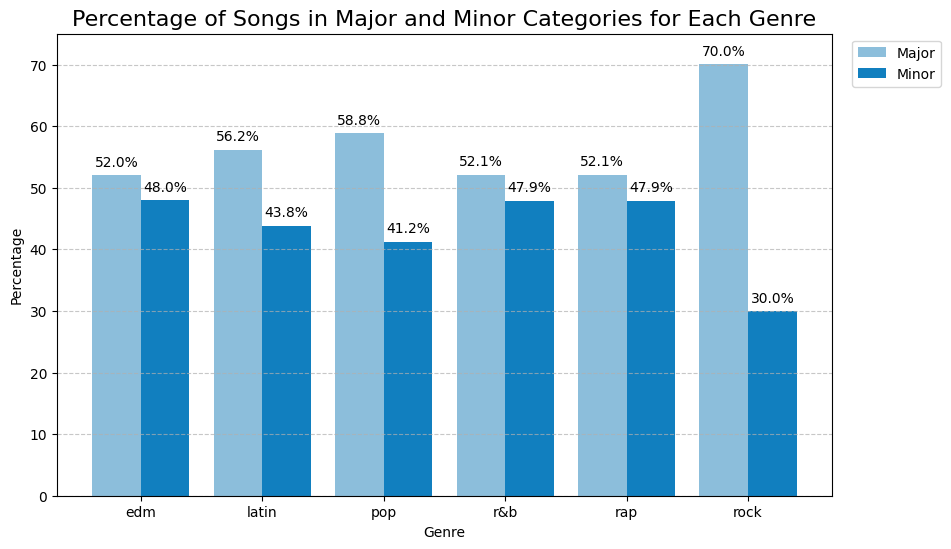

In [59]:
df['mode_name'] = df['mode'].replace({1: 'major', 0: 'minor'})

# major & minor distribution
genre_counts = df.groupby(['playlist_genre', 'mode_name']).size().unstack(fill_value=0)

# calculate the percentage of major and minor
total_counts = genre_counts.sum(axis=1)
major_percentages = (genre_counts['major'] / total_counts) * 100
minor_percentages = (genre_counts['minor'] / total_counts) * 100

# Plot the bar chart with percentages
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.4
bar_positions_major = np.arange(len(genre_counts.index))
bar_positions_minor = bar_positions_major + bar_width

major_bars = ax.bar(bar_positions_major, major_percentages, width=bar_width, label='Major', color='#8cbedb')
minor_bars = ax.bar(bar_positions_minor, minor_percentages, width=bar_width, label='Minor', color='#117fbf')

ax.set_xlabel('Genre')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Songs in Major and Minor Categories for Each Genre', fontsize = 16)
ax.set_xticks(bar_positions_major + bar_width / 2)
ax.set_xticklabels(genre_counts.index)
ax.legend(bbox_to_anchor=(1.15, 1),loc = 'upper right')
ax.set_ylim([0, 75])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# add percentage number on top of the bars
for bar, percentage in zip(major_bars, major_percentages):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{percentage:.1f}%', ha='center', va='bottom')

for bar, percentage in zip(minor_bars, minor_percentages):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{percentage:.1f}%', ha='center', va='bottom')

plt.show()

We look into how keys are distributed for each genre of music by using pie chart to visualize the proportion.

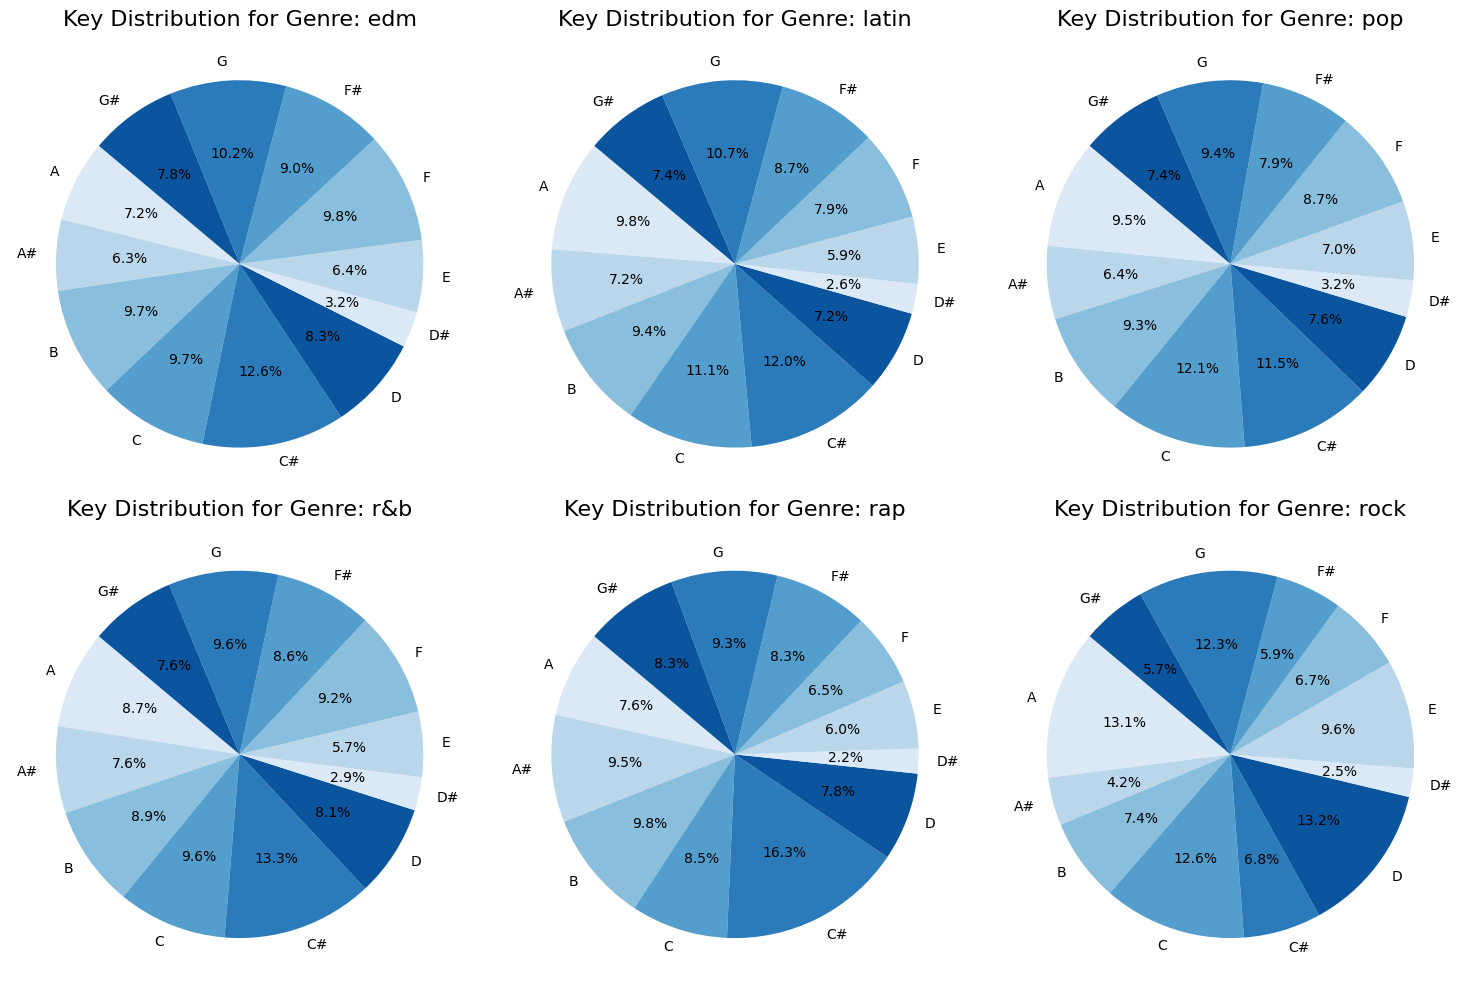

In [60]:
# key distribution

# convert numeric key representation to the corresponding signatures
key_signatures = {
    0:'C',
    1:'C#',
    2:'D',
    3:'D#',
    4:'E',
    5:'F',
    6:'F#',
    7:'G',
    8:'G#',
    9:'A',
    10:'A#',
    11:'B'
}

# mapping and create a new column to store the key signatures
df['key_signature'] = df['key'].map(key_signatures)
key_signature_counts = df.groupby(['playlist_genre', 'key_signature']).size().reset_index(name='count')

genres = key_signature_counts['playlist_genre'].unique()

# Plot pie charts in a 2x3 grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, genre in enumerate(genres):
    genre_data = key_signature_counts[key_signature_counts['playlist_genre'] == genre]

    # assign to the right row and column based on the remainder of being divded by 3
    row, col = divmod(i, 3)
    ax = axes[row, col]

    ax.pie(genre_data['count'], labels=genre_data['key_signature'], autopct='%1.1f%%', colors=sns.color_palette('Blues'), startangle=140)
    ax.set_title(f'Key Distribution for Genre: {genre}', fontsize = 16)

plt.tight_layout()
plt.show()


We can conclude from the pie chars above that except for the "rock" genre, C# is the dominant key for the remaining five genres of songs, with D being the dominant one for the "rock" genre.

### Distribution with respect to time

Because our goal is to generate an optimal month for recording companies to release a song, it is crucial to verify the distribution of releasing month before any other action.

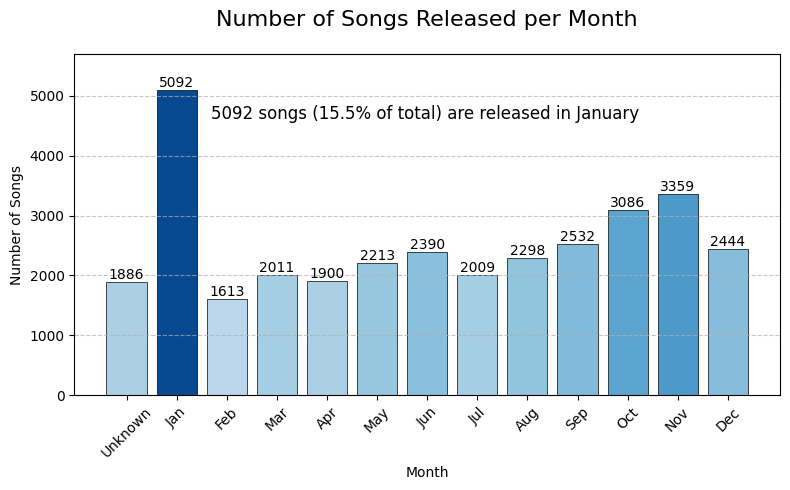

In [61]:
# First, sort month_count by the month index to ensure correct order
month_count = df['month'].value_counts()
month_count = month_count.sort_index()

# Define the month names for the x-axis labels
month_names = ['Unknown', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

color_intensity = month_count / month_count.max()   # For defining color gradient

# Now, we adjust the month_count plot to add an annotation for the month with the most songs
max_month = int(month_count.idxmax())
max_songs = month_count.max()
original_song_count = df.shape[0]
percentage_max_month = max_songs = month_count.max() / original_song_count * 100

# Generate the bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(month_names, month_count, color=plt.cm.Blues(0.9 * color_intensity), width=0.8, edgecolor='black', linewidth=0.5)

# Explicitly showing the number of songs on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# Annotating the percentage of the month with the most songs
plt.annotate(f'{month_count[max_month]} songs ({percentage_max_month:.1f}% of total) are released in January',
             xy=(max_month-1, max_songs),
             xytext=(0.8, 0.85),
             textcoords='axes fraction',
             ha='right',
             va='top',
             fontsize=12,
             color='black')

# Adding gridlines to the background
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.title('Number of Songs Released per Month', fontsize=16, pad=20)
plt.xlabel('Month')
plt.ylabel('Number of Songs')
plt.ylim([0,5700])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This distribution is **abnormal** because we naturally expect similar number of songs being published every month. An extreme high peak in January indicates that there might be other defaults in data processing or data collection. So we want to trouble shoot and make sure all data are valid.



In [62]:
# Check the data distribution within each decade to conduct real-quick bug-shotting
pd.set_option('display.max_rows', None)
grouped_data = df.groupby('decade')['month'].value_counts()
sorted_data = grouped_data.sort_index()

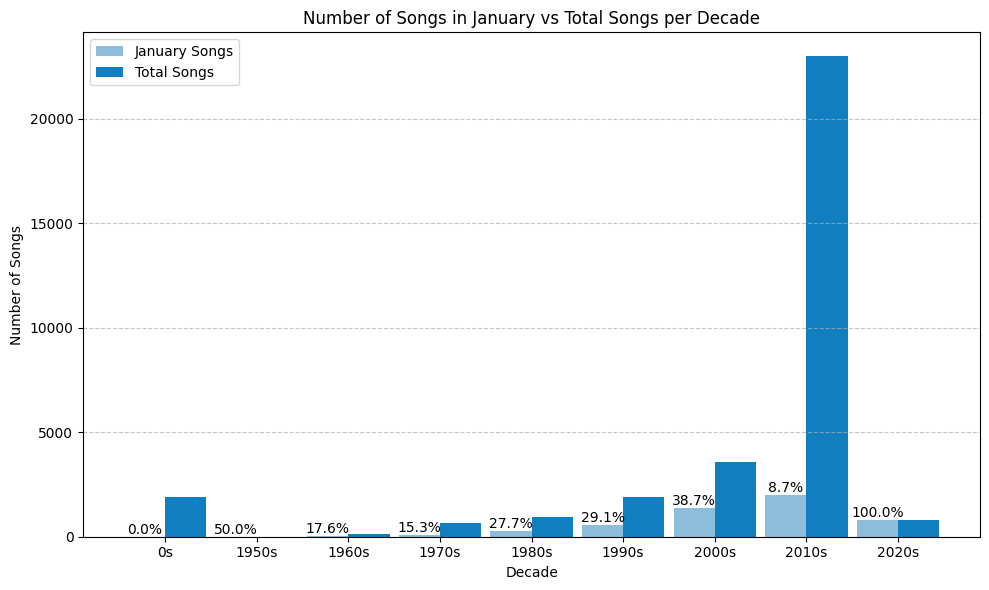

In [63]:
# Extracting January song counts for each decade (where month is 1)
january_songs_per_decade = sorted_data.xs(1, level='month')

# To ensure all decades are represented, even if they don't have any songs in January
decades = sorted_data.index.get_level_values(0).unique()    # Get a list of all decades
january_songs_per_decade = january_songs_per_decade.reindex(decades, fill_value=0)

# Now extracting number of songs per decade
total_songs_per_decade = df.groupby('decade').size()
january_counts = january_songs_per_decade.values            # January song counts
total_counts = total_songs_per_decade.values                # Total song counts

# Plotting the bar chart with specified adjustments
plt.figure(figsize=(10, 6))
bar_width = 0.45  # Thicker bars
r1 = np.arange(len(decades))
r2 = [x + bar_width for x in r1]

# Define colors
light_pink = '#FFC0CB'
light_blue = '#ADD8E6'

plt.bar(r1, january_counts, width=bar_width, color='#8cbedb', label='January Songs')
plt.bar(r2, total_counts, width=bar_width, color='#117fbf', label='Total Songs')

# Adding the proportion of January songs on top of each bar
for i in range(len(decades)):
    jan_percentage = (january_counts[i] / total_counts[i]) * 100 if total_counts[i] != 0 else 0
    plt.text(r1[i], january_counts[i], f'{jan_percentage:.1f}%', ha='center', va='bottom')

plt.xlabel('Decade')
plt.ylabel('Number of Songs')
plt.title('Number of Songs in January vs Total Songs per Decade')
plt.xticks([r + bar_width / 2 for r in range(len(decades))], decades)
plt.legend()

# Adding gridlines to the background
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



Distribution seems to make more sense in the 2010s. We check the dataset manually realized that an abnormal number of older songs are "published" on Jan 1st, which in fact they were not. This makes a lot sense to us since Spotify is founded in 2006, and online streaming of music gradually took the place of physical albums since then.

In [64]:
# Count the number of songs per decade again
decade_counts = df['decade'].value_counts().sort_index()

# Check if the number of modifted data match the original dataset
decade_song_count = decade_counts.sum()

# original_song_count, decade_song_count

percentage_2010s = (decade_counts.get('2010s', 0) / original_song_count) * 100

decade_counts, percentage_2010s

(decade
 0s        1886
 1950s        2
 1960s      131
 1970s      646
 1980s      954
 1990s     1879
 2000s     3565
 2010s    22985
 2020s      785
 Name: count, dtype: int64,
 70.00578686078032)

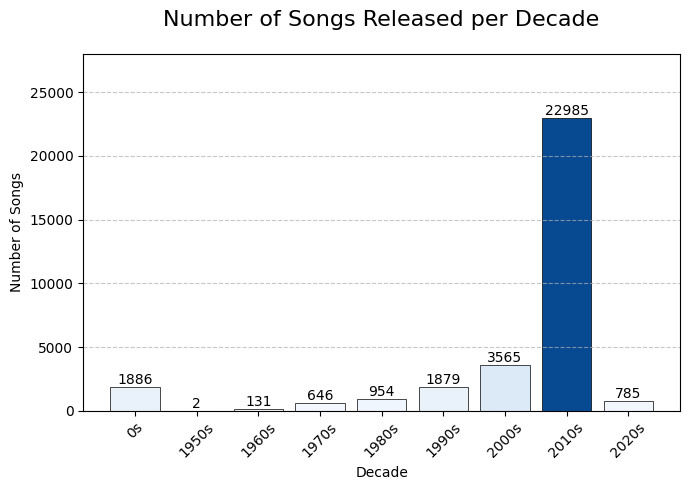

In [65]:
# Normalize the color intensity for a more subtle difference
decade_color_intensity = (decade_counts - decade_counts.min()) / (decade_counts.max() - decade_counts.min())
decade_colors = plt.cm.Blues(0.9 * decade_color_intensity)  # Adjusting color range for more subtlety

# Generate the bar chart for decades
plt.figure(figsize=(7, 5))
bars = plt.bar(decade_counts.index.astype(str), decade_counts, color=decade_colors, width=0.8, edgecolor='black', linewidth=0.5)

# Explicitly showing the number of songs on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# Title and labels
plt.title('Number of Songs Released per Decade', fontsize=16, pad=20)
plt.xlabel('Decade')
plt.ylabel('Number of Songs')
plt.ylim([0,28000])
plt.xticks(rotation=45)

# Adding gridlines to the background
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


The dataset contains 70.7% songs from the 2010s and was collected on Jan 17 2020, resulting in the the weird distribution of months for 2020s.

Again considering the history of music streaming industry, we see that this is a problem in data collection of this dataset. Notice that we have abundant data for training within the 2010s, we decide to filter data only in the 2010s for more precise results. More recent data will speak stronger, but we don't currently have access to those data.

For our predictive model for optimal releasing month, it is reasonable to focus on songs that are published directly online instead of including those that are uploaded to Spotify years after its publication.


In [71]:
# Create a new dataframe that filtered data only within the 2010s
df_2010s = df[(df['decade'] == '2010s')]
month_count_2010s = df_2010s['month'].value_counts()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (13,) and arg 1 with shape (12,).

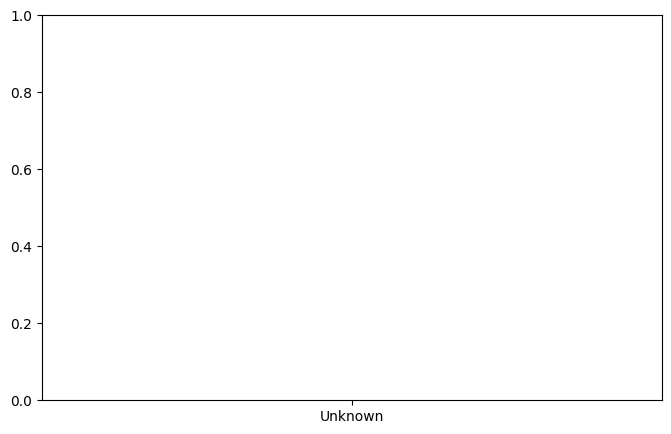

In [72]:


# Check the month distribution again to see if the distribution match our expectation now
month_count_2010s = month_count_2010s.sort_index()

color_intensity = month_count_2010s / month_count_2010s.max()   # For defining color gradient

# Now, we adjust the month_count plot to add an annotation for the month with the most songs
max_month_2010s = month_count_2010s.idxmax()
max_songs_2010s = month_count_2010s.max()
song_count_2010s = df_2010s.shape[0]
percentage_max_month_2010s = month_count_2010s.max() / song_count_2010s * 100

# Generate the bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(month_names, month_count_2010s, color=plt.cm.Blues(0.9 * color_intensity), width=0.8, edgecolor='black', linewidth=0.5)

# Explicitly showing the number of songs on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# Annotating the percentage of the month with the most songs
plt.annotate(f'{month_count_2010s[max_month_2010s]} songs ({percentage_max_month_2010s:.1f}% of total) are released in {month_names[max_month_2010s]}',
             xy=(max_month_2010s-1, max_songs_2010s),
             xytext=(0.9, 0.9),
             textcoords='axes fraction',
             ha='right',
             va='top',
             fontsize=12,
             color='black')

# Adding gridlines to the background
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.title('Number of Songs Released per Month', fontsize=16, pad=20)
plt.xlabel('Month')
plt.ylabel('Number of Songs')
plt.ylim([0,3700])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The above visualization proves that with our modulation, the dataset is prepared better for feeding into a ML model.

### Distribution with respect to popularity

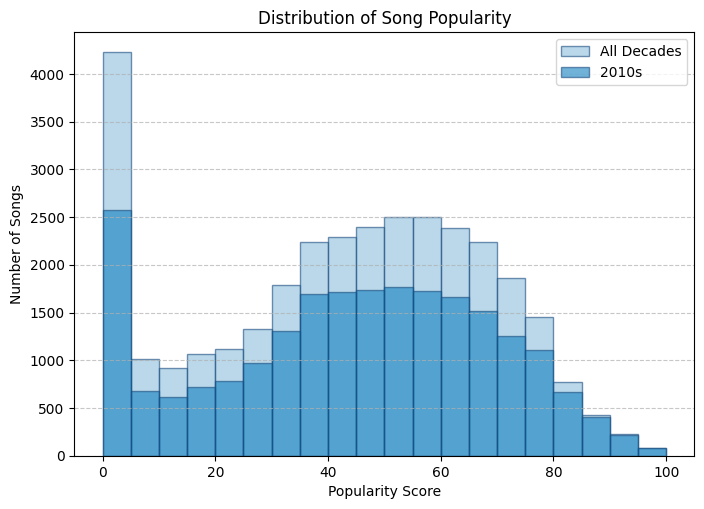

In [ ]:
# Plotting the distribution of song popularity for the entire dataset and for the 2010s on the same graph
plt.figure(figsize=(8, 5.5))

# Plot for the entire dataset
plt.hist(df['track_popularity'], bins=20, color='#8cbedb', alpha=0.6, edgecolor='#174a7e', label='All Decades')

# Plot for the 2010s
plt.hist(df_2010s['track_popularity'], bins=20, color='#117fbf', alpha=0.6, edgecolor='#174a7e', label='2010s')

plt.title('Distribution of Song Popularity')
plt.xlabel('Popularity Score')
plt.ylabel('Number of Songs')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


The proportion of 0 popularity is large; based on the description provided for the dataset features, 0 is thought to be a meaningful entry instead of a missing value. We will treat songs with popularity being 0 as songs never being heard or hasn't been played for a long period of time.

### Trend over Time

1. Genre Trend over Time

As we mentioned before, Spotify was founded in 2006. We can first visualize that, from 2006 to 2020, what is the proportion of each genre of songs and then come up with the dominant genre of the year.

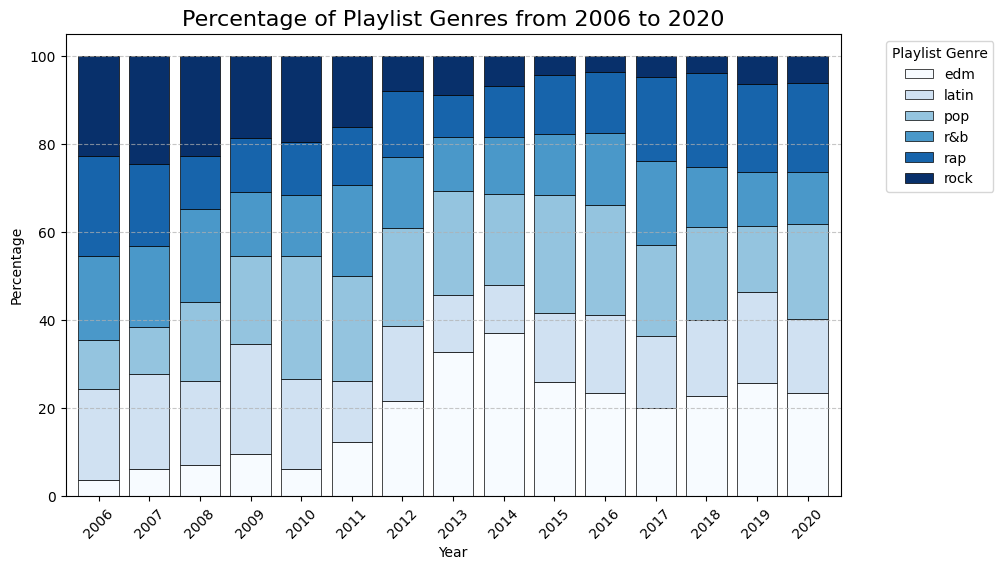

In [ ]:

spotify = df[(df['year'] <= 2020) & (df['year'] >= 2006)]
genre = spotify.groupby(['year','playlist_genre'])['playlist_genre'].size()
genre_df = pd.DataFrame(list(genre.items()), columns=['Year_Playlist_Genre', 'Count'])

# split 'Year_Playlist_Genre' column
genre_df[['Year', 'Playlist_Genre']] = genre_df['Year_Playlist_Genre'].apply(lambda x: pd.Series(str(x).split(',')))
genre_df['Playlist_Genre'] = genre_df['Playlist_Genre'].apply(lambda x: x[2:-2])
genre_df['Year'] = genre_df['Year'].apply(lambda x: x[1:])
genre_df['Count'] = pd.to_numeric(genre_df['Count'])

pivot_genre_df = genre_df.pivot(index='Year', columns='Playlist_Genre', values='Count')

# derive the genre with max songs for each year
max_genre_df = genre_df.loc[genre_df.groupby('Year')['Count'].idxmax()]

# Group by year and playlist_genre and calculate the percentage
genre_percentage = spotify.groupby(['year', 'playlist_genre']).size() / spotify.groupby('year').size() * 100

# Convert the result to a DataFrame
genre_df = pd.DataFrame(genre_percentage.reset_index(name='Percentage'))

# Pivot to get 'playlist_genre' as columns
pivot_genre_df = genre_df.pivot(index='year', columns='playlist_genre', values='Percentage')

# Plot the bar chart
pivot_genre_df.plot(kind='bar', stacked=True, figsize=(10, 6), width=0.8, cmap='Blues', edgecolor='black', linewidth=0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Percentage of Playlist Genres from 2006 to 2020', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Playlist Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

2. Dominant Genre over Time

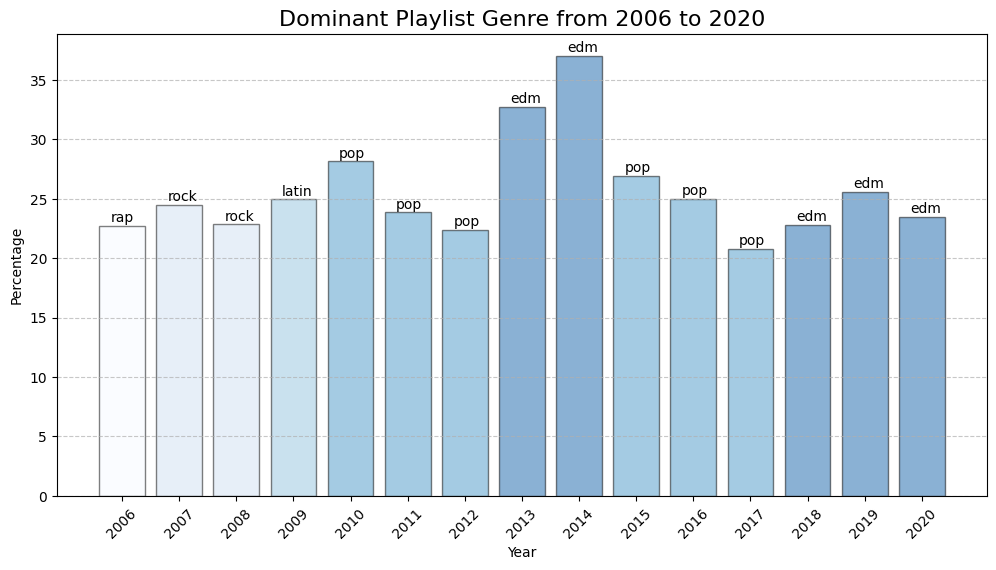

In [ ]:
unique_genres = genre_df['playlist_genre'].unique()

# get the unique genre and assign color to each of genre
genre_colors = {genre: plt.cm.Blues(i / len(max_genre_df['Playlist_Genre'].unique()))
                for i, genre in enumerate(max_genre_df['Playlist_Genre'].unique())}

# plot the dominant genre for each year with labels
plt.figure(figsize=(12, 6))
bars = plt.bar(max_genre_df['Year'], genre_percentage.groupby('year').max(), color=[genre_colors[genre] for genre in max_genre_df['Playlist_Genre']],edgecolor='black', alpha = 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# put label on each of them
for bar, genre in zip(bars, max_genre_df['Playlist_Genre']):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.2, bar.get_height() + 0.1, genre, ha='left', va='bottom')

plt.title('Dominant Playlist Genre from 2006 to 2020', fontsize = 16)
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.show()

After Spotify has established, EDM and Pop became to the two dominant genres from 2006 to 2020, with several exception from 2006 to 2009.

3. Music Feature Distribution with respect to time

<ipython-input-26-b39d87c7858f>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby('year').mean().reset_index()


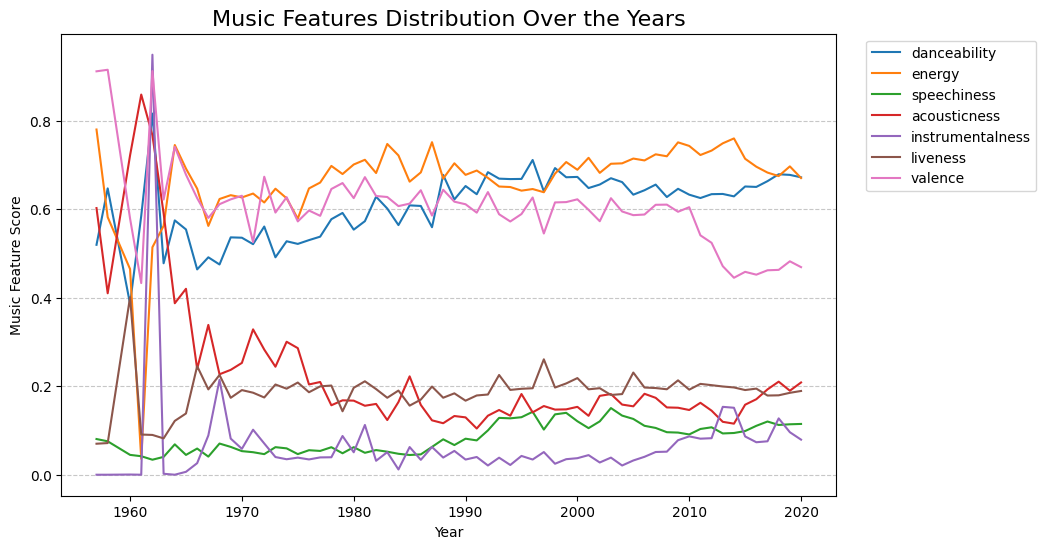

In [ ]:
# extract feature columns
feature_column = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']

# get the average for each year
grouped_df = df.groupby('year').mean().reset_index()

# plotting the lines
plt.figure(figsize=(10, 6))
for feature in feature_column:
    plt.plot(grouped_df['year'], grouped_df[feature], label=feature)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xlabel('Year')
plt.ylabel('Music Feature Score')
plt.title('Music Features Distribution Over the Years', fontsize = 16)
plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left')

plt.show()

**Music Feature Pattern for 2010s**

Given the dataset contains the most of songs from the 2010s, we will simply use the 2010s data to conduct the music feature pattern analysis to avoid any kind of bias.

### Does the streaming date matter?
Artists in the real world generally have their reasons to write a particular song as they wish. In other words, music feature is kind of fixed and it is left for recording companies to pick a suitable time to publish the art. Sometimes a decision can be quite wrong, for example, publishing a gentle and Christmas vibe song in summer. Thus, we are interested in predicting the best timing for companies to publish a song given all other features.

#### Second round data processing

#### Visualization of popularity w.r.t. months

We first check how average popularity change with months.

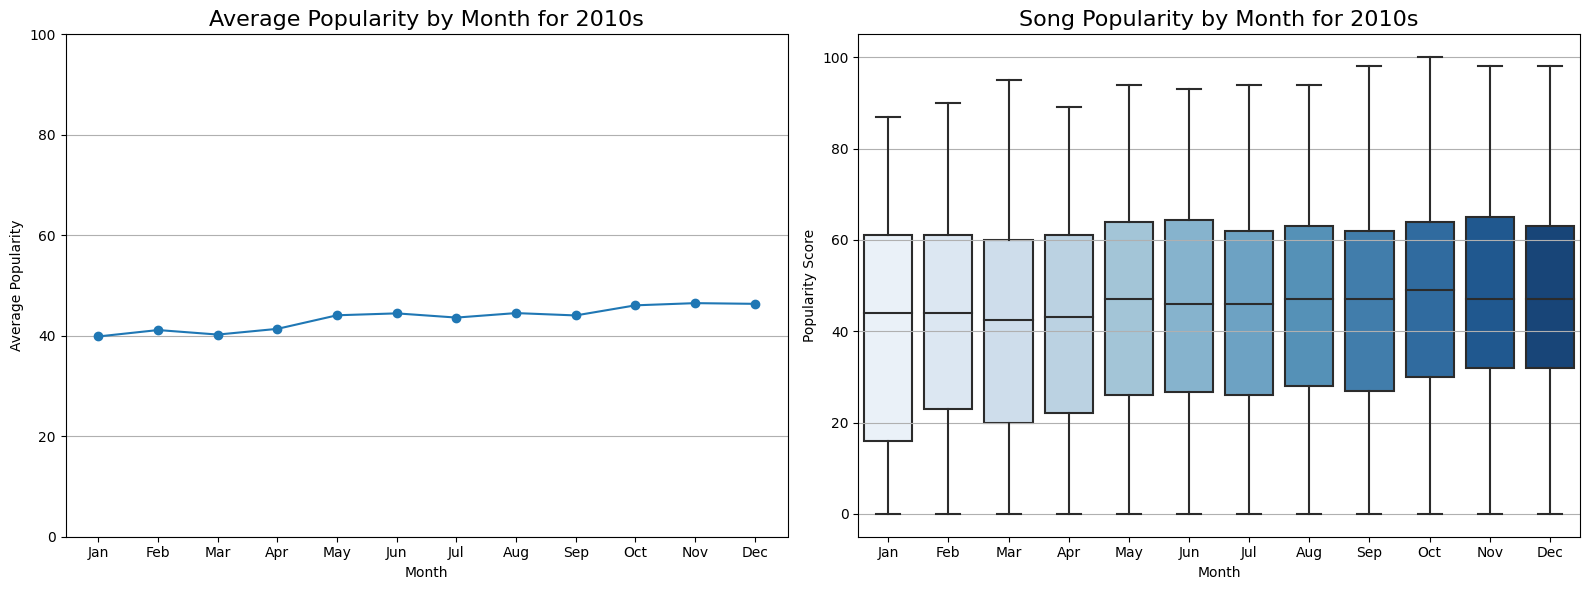

In [ ]:
# Filter songs with known streaming month
decade2010s_filtered = df_2010s[df_2010s['month'].between(1, 12)]

# calculate the average popularity score for each month for the entire 2010s
popularity_month = decade2010s_filtered.groupby('month')['track_popularity'].mean().reset_index()

# Create two subplots: one for the line plot and one for the box plot
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Line plot for average popularity by month
axs[0].plot(popularity_month['month'], popularity_month['track_popularity'], marker='o', color='#1f77b4')
axs[0].set_title('Average Popularity by Month for 2010s', fontsize=16)
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Average Popularity')
axs[0].set_xticks(range(1, 13))
axs[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axs[0].grid(axis='y')
axs[0].set_ylim([0, 100])

# Box plot for song popularity by month
sns.boxplot(x='month', y='track_popularity', data=decade2010s_filtered, ax=axs[1], palette='Blues')
axs[1].set_title('Song Popularity by Month for 2010s', fontsize=16)
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Popularity Score')
axs[1].set_xticks(range(0, 12))
axs[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axs[1].grid(axis='y')

plt.tight_layout()
plt.show()

From the above graph, we see that songs realeased later that year tend to have slightly higher popularity score compared to the first half of the year. It's natural to wonder why.

#### Hypothesis test for difference in popularity distribution in months

As we checked the defintion of "popularity" for this dataset again, we learned that new clickings results in a higher score, i.e. a song that is played 100 thousand times last year will have a lower score than a song with same clicks this year. Such definition results in bias in average scores within each month.

In order to decide if we need to take further step process such differnece, **we conduct a Mann-Whitney U test before proceeding to further steps.** We simply take the extreme cases, January and December, for our test.

- **Null Hypothesis (H0):** There is no difference in the popularity distribution between January and December.

- **Alternative Hypothesis (H1):** There is a difference in the popularity distribution between January and December.

In [ ]:
from scipy.stats import mannwhitneyu

# Extracting the popularity scores for January and December
popularity_january = decade2010s_filtered[decade2010s_filtered['month'] == 1]['track_popularity']
popularity_december = decade2010s_filtered[decade2010s_filtered['month'] == 12]['track_popularity']

# Performing the Mann-Whitney U test
stat, p_value = mannwhitneyu(popularity_january, popularity_december, alternative='two-sided')

# Display results
print(f"P-value for observed difference: {p_value}")

# Interpret the results
if p_value < 0.005:
    print("The observed difference is statistically significant at the 0.005 level, supporting the alternative hypothesis.")
else:
    print("The observed difference is not statistically significant at the 0.005 level.")

P-value for observed difference: 7.645780571838502e-12
The observed difference is statistically significant at the 0.005 level, supporting the alternative hypothesis.


To address potential time-related biases in song popularity scores, we calculated adjustment factors for each month. These factors were based on the average popularity difference between January and December, divided evenly across all months. This approach aims to **linearly distribute the observed annual variation in popularity**, enabling more accurate comparisons while keeping potential difference in average in every month caused by other factors.

#### Regularize popularity score

In [ ]:
# Calculate the average popularity for January and December
avg_popularity_january = popularity_month[popularity_month['month'] == 1]['track_popularity'].values[0]
avg_popularity_december = popularity_month[popularity_month['month'] == 12]['track_popularity'].values[0]

# Calculate the difference and divide it by 11 (to distribute across months)
popularity_difference = avg_popularity_december - avg_popularity_january
monthly_adjustment = popularity_difference / 11

# Generate adjustment factors for each month
adjustment_factors = {month: 1 + (12 - month) * monthly_adjustment / 100 for month in range(1, 13)}

# Adjusting the calculation to apply the factor as a percentage increase
for month in range(1, 13):
    factor = adjustment_factors[month]
    decade2010s_filtered.loc[decade2010s_filtered['month'] == month, 'adjusted_popularity'] = decade2010s_filtered[decade2010s_filtered['month'] == month]['track_popularity'] * factor

# Normalize the adjusted popularity scores to a scale of 0 to 100
max_adjusted_popularity = decade2010s_filtered['adjusted_popularity'].max()
decade2010s_filtered['normalized_popularity'] = (decade2010s_filtered['adjusted_popularity'] / max_adjusted_popularity) * 100

# Displaying the first few rows again to verify the updated column
decade2010s_filtered[['track_popularity', 'normalized_popularity']].head()

,track_popularity,normalized_popularity
0,66,67.539718
1,67,66.218477
2,70,71.224775
3,60,61.049808
4,69,71.816984


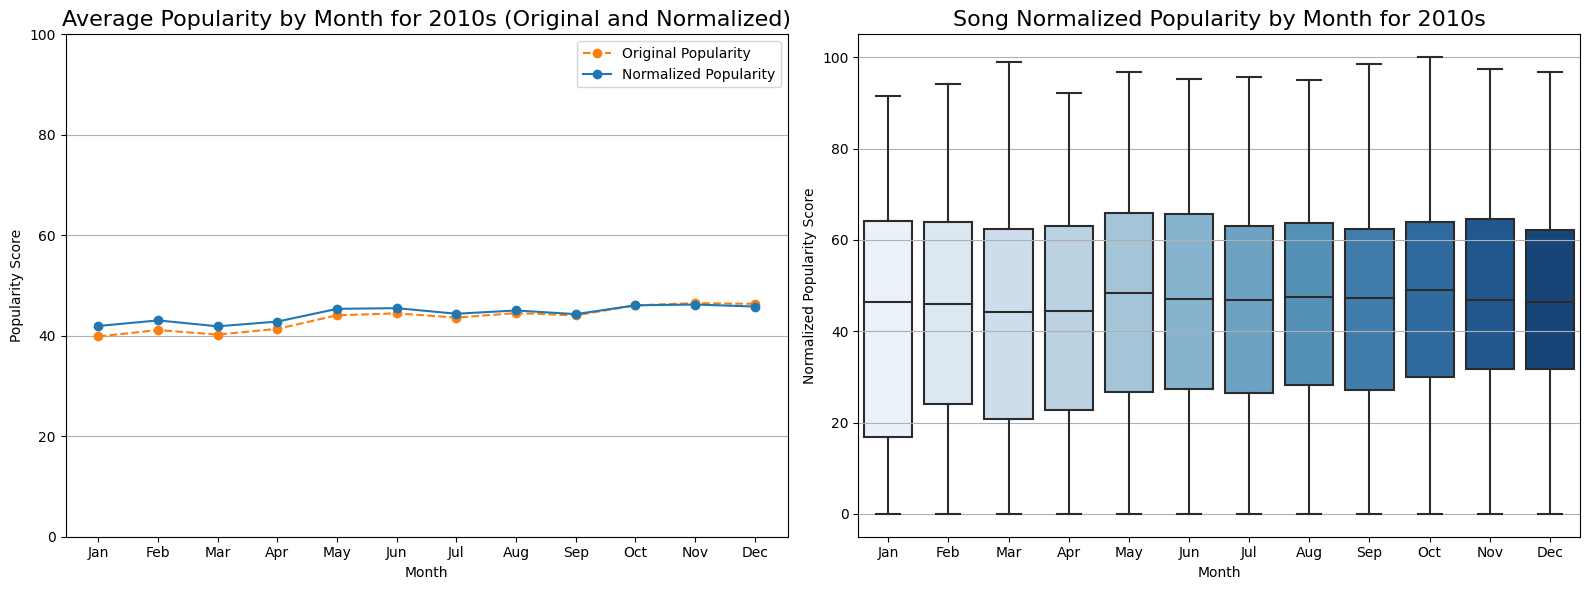

In [ ]:
# Recalculate the average normalized popularity score for each month for the entire 2010s
popularity_month_normalized = decade2010s_filtered.groupby('month')['normalized_popularity'].mean().reset_index()

# Create two subplots: one for the line plots and one for the box plot
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Line plot for average original and normalized popularity by month
axs[0].plot(popularity_month['month'], popularity_month['track_popularity'], linestyle='--', marker='o', color='#ff7f0e', label='Original Popularity')
axs[0].plot(popularity_month_normalized['month'], popularity_month_normalized['normalized_popularity'], marker='o', color='#1f77b4', label='Normalized Popularity')
axs[0].set_title('Average Popularity by Month for 2010s (Original and Normalized)', fontsize=16)
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Popularity Score')
axs[0].set_xticks(range(1, 13))
axs[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axs[0].grid(axis='y')
axs[0].set_ylim([0, 100])
axs[0].legend()

# Box plot for song normalized popularity by month
sns.boxplot(x='month', y='normalized_popularity', data=decade2010s_filtered, ax=axs[1], palette='Blues')
axs[1].set_title('Song Normalized Popularity by Month for 2010s', fontsize=16)
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Normalized Popularity Score')
axs[1].set_xticks(range(0, 12))
axs[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axs[1].grid(axis='y')

plt.tight_layout()
plt.show()


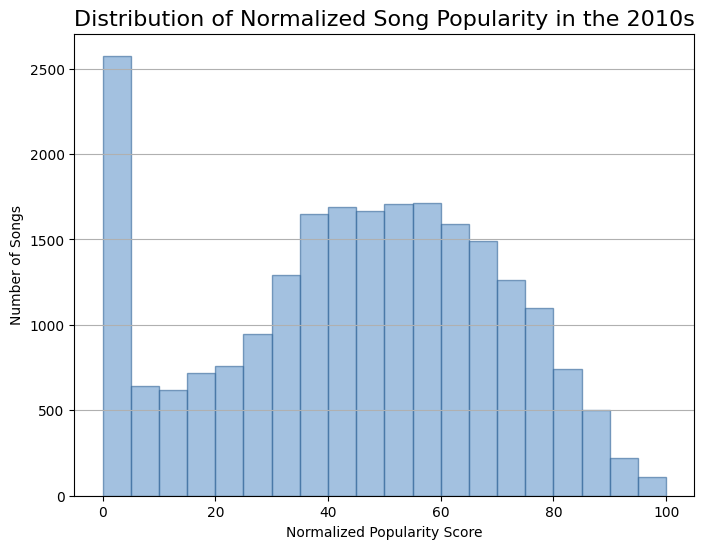

In [ ]:
# Plotting the histogram of the normalized popularity scores
plt.figure(figsize=(8, 6))
plt.hist(decade2010s_filtered['normalized_popularity'], bins=20, color='#6699cc', alpha=0.6, edgecolor='#336699')
plt.title('Distribution of Normalized Song Popularity in the 2010s', fontsize=16)
plt.xlabel('Normalized Popularity Score')
plt.ylabel('Number of Songs')
plt.grid(axis='y')
plt.show()

### Multicolinearity Analysis

In [ ]:
# get the correlations
corr_matrix = df.corr()
corr_matrix

<ipython-input-32-ffcc85712d7b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,month,year
track_popularity,1.000000,0.064748,-0.109112,-0.000650,0.057687,0.010637,0.006819,0.085159,-0.149872,-0.054584,0.033231,-0.005378,-0.143682,0.093728,0.060744
danceability,0.064748,1.000000,-0.086073,0.011736,0.025335,-0.058647,0.181721,-0.024519,-0.008655,-0.123859,0.330523,-0.184084,-0.096879,0.056143,0.161358
energy,-0.109112,-0.086073,1.000000,0.010052,0.676625,-0.004800,-0.032150,-0.539745,0.033247,0.161223,0.151103,0.149951,0.012611,-0.024428,0.041505
key,-0.000650,0.011736,0.010052,1.000000,0.000959,-0.174093,0.022607,0.004306,0.005968,0.002887,0.019914,-0.013370,0.015139,0.007245,0.006461
loudness,0.057687,0.025335,0.676625,0.000959,1.000000,-0.019289,0.010339,-0.361638,-0.147824,0.077613,0.053384,0.093767,-0.115058,0.056575,0.296717
mode,0.010637,-0.058647,-0.004800,-0.174093,-0.019289,1.000000,-0.063512,0.009415,-0.006741,-0.005549,0.002614,0.014329,0.015634,-0.031080,-0.092272
speechiness,0.006819,0.181721,-0.032150,0.022607,0.010339,-0.063512,1.000000,0.026092,-0.103424,0.055426,0.064659,0.044603,-0.089431,0.025069,0.106880
acousticness,0.085159,-0.024519,-0.539745,0.004306,-0.361638,0.009415,0.026092,1.000000,-0.006850,-0.077243,-0.016845,-0.112724,-0.081581,0.028467,0.010294
instrumentalness,-0.149872,-0.008655,0.033247,0.005968,-0.147824,-0.006741,-0.103424,-0.006850,1.000000,-0.005507,-0.175402,0.023335,0.063235,0.042053,0.086060
liveness,-0.054584,-0.123859,0.161223,0.002887,0.077613,-0.005549,0.055426,-0.077243,-0.005507,1.000000,-0.020560,0.021018,0.006138,-0.017535,-0.017936


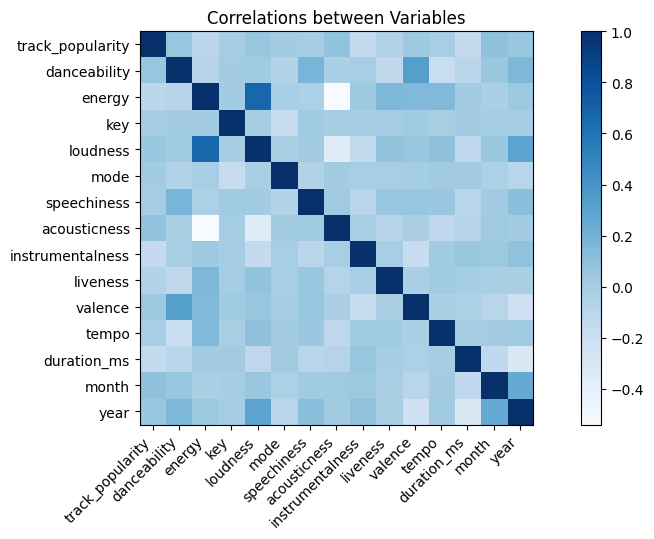

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5.5)
im = ax.imshow(corr_matrix, cmap='Blues')

ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
ax.set_yticklabels(corr_matrix.columns, rotation=0)

ax.set_title('Correlations between Variables')
fig.colorbar(im)
fig.tight_layout()


The heatmap indicates a general trend of variable correlations within the dataset. Notably, 'energy' and 'loudness' display a moderately strong positive correlation, suggesting that tracks with higher energy often exhibit greater loudness, aligning with intuitive expectations about musical characteristics. This suggests that we should be careful if including both into our predictive model.

## **Feature Engineering**

### Data Preparation for Feature Engineering and Model

In [ ]:
# Use df_2010s to train the model and df_2020s to test the model
df_2010s = df[(df['decade'] == '2010s')]
df_2020s = df[(df['decade'] == '2020s')]

In [ ]:
numerical_data_2010s = df_2010s.select_dtypes(include='number')
categorical_2010s = df_2010s[df_2010s.columns.drop(list(numerical_data_2010s.columns))]

numerical_data_2020s = df_2020s.select_dtypes(include='number')
categorical_2020s = df_2020s[df_2020s.columns.drop(list(numerical_data_2020s.columns))]


In [ ]:
def categorical_data_preparation(categorical_data):
  # as we do not care the exact date of release, the playlist name and decade, we will drop them
  categorical_data.drop(['track_album_release_date','playlist_name','decade','mode_name','key_signature'], axis=1, inplace=True)

  # for genre and subgenre, we will use one-hot encoding
  genre_map = pd.get_dummies(categorical_data['playlist_genre'],prefix='genre')
  subgenre_map = pd.get_dummies(categorical_data['playlist_subgenre'],prefix='subgenre')

  categorical_data = pd.concat([categorical_data.drop(['playlist_genre','playlist_subgenre'],axis=1),genre_map,subgenre_map],axis=1)
  return categorical_data

In [ ]:
categorical_2010s = categorical_data_preparation(categorical_2010s)
categorical_2020s = categorical_data_preparation(categorical_2020s)

In [ ]:
data10s = pd.concat([numerical_data_2010s, categorical_2010s], axis=1)
data20s = pd.concat([numerical_data_2020s, categorical_2020s], axis=1)

In [ ]:
# make the problem into binary classification. We define a song as popular if the track_popularity is above median, otherwise unpopular
pop_thre = data10s.track_popularity.median()
data10s['popular'] = data10s.track_popularity.apply(lambda x: int(x > pop_thre))
data10s_classification = data10s.drop(columns = ['track_popularity'])

data20s['popular'] = data20s.track_popularity.apply(lambda x: int(x > pop_thre))
data20s_classification = data20s.drop(columns = ['track_popularity'])

### Feature Selection
As high demension data may result in overfit and model diverge, we applied different methods to select features that are highly influential to the outcome and build our model based on this subset

#### RF selection

Random forest assign importance to each feature according to the gini-impurity. We use it as a start point of our feature selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from collections import defaultdict
# a function returns the selected features and their importance score less than or equal to the threshold
def threhshold_feature_selection(df, threshold = 0):
  x = df.iloc[:, :-1]
  y = df.iloc[:, -1]
  rf = RandomForestClassifier(n_estimators=100, random_state=42)
  rf.fit(x, y)

  feature_importance_dict = dict(zip(x.columns, rf.feature_importances_))
  sorted_features = dict(sorted(feature_importance_dict.items(), key=lambda x: -x[1]))

  res = defaultdict(int)
  for k, v in sorted_features.items():
    if v >= threshold:
      res[k] = v
  return res

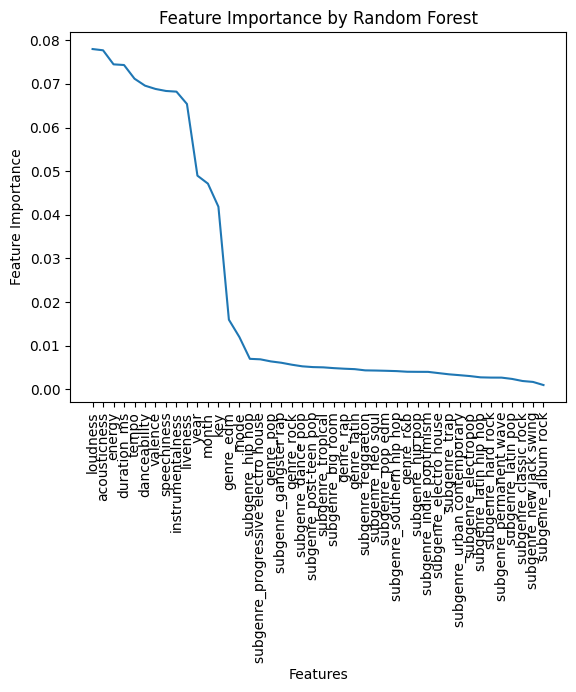

In [ ]:
# visualize the distribution of the importance score for all of the features
feat_importance = threhshold_feature_selection(data10s_classification)
plt.plot(feat_importance.keys(),feat_importance.values())
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importance by Random Forest')
plt.xticks(rotation=90);

From the plot we could see that importance score faced a sharp decrease at "key". Thus, we decided to choose features that has feature importance greater than or equal to the key's feature importance.

In [ ]:
selected_feat = threhshold_feature_selection(data10s_classification, feat_importance['key'])

In [ ]:
#print out selected features
selected_features_rf = list(selected_feat.keys())
print(selected_features_rf)

['loudness', 'acousticness', 'energy', 'duration_ms', 'tempo', 'danceability', 'valence', 'speechiness', 'instrumentalness', 'liveness', 'year', 'month', 'key']


#### Chi-square selection

As the random forest selection only selected numerical data, we need to use chi-squre test to see if the categorical data also have significant influence on the results

In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
chi_res = {}
# some categories only existed in 2010 or 2020. To make the feature engineering consistent, we only consider features
# exist in both decades
categories = set(categorical_2020s.columns) & set(categorical_2010s.columns)
# chi-squre to test whether the categorical feature has significant influence on the target variable
for feature in categories:
    contingency_table = pd.crosstab(categorical_2010s[feature], data10s_classification['popular'])

    # Perform the chi-square test
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # store the results
    chi_res[feature] = {'Chi2': chi2, 'Pvalue':p, 'Significant': p<0.05}

chi_res_df = pd.DataFrame.from_dict(chi_res).T
chi_res_df

,Chi2,Pvalue,Significant
genre_rap,60.361038,0.0,True
subgenre_hip hop,302.817173,0.0,True
subgenre_progressive electro house,473.484037,0.0,True
subgenre_indie poptimism,0.678187,0.410212,False
subgenre_electropop,5.243482,0.022029,True
subgenre_latin hip hop,35.845448,0.0,True
subgenre_pop edm,0.564093,0.452616,False
subgenre_big room,312.787441,0.0,True
subgenre_urban contemporary,90.153886,0.0,True
subgenre_classic rock,95.480595,0.0,True


The below figure shows the P-value for Chi-square test between each feature and popularity

we can see that most of the categorical features have significant influence on the popularity

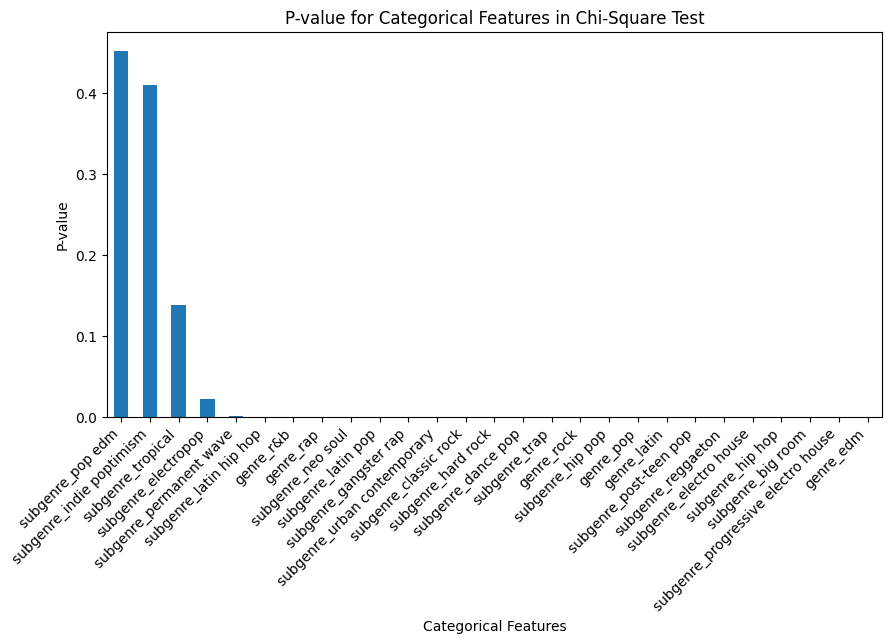

In [ ]:
chi_res_df.Pvalue.sort_values(ascending=False).plot(kind='bar',figsize=(10,5))
plt.xlabel('Categorical Features')
plt.ylabel('P-value')
plt.title('P-value for Categorical Features in Chi-Square Test')
plt.xticks(rotation = 45, ha = 'right');

In [ ]:
selected_feature_chi = list(chi_res_df[chi_res_df.Significant].index)

#### PCA
As there are too many significant categorical data, we will use PCA to densify these sparse features

In [ ]:
orig_cate_feat = categorical_2010s[selected_feature_chi]
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(orig_cate_feat)
pca.explained_variance_ratio_

array([0.17679121, 0.14511085, 0.13737071, 0.123444  , 0.06001964,
       0.04297426, 0.03487792, 0.03283211, 0.03088466, 0.03064268])

The following figure shows the expalained varience in each direction. As there is a sharp drop at the 5th direction, we only keep the first 4 abstract components as our feature

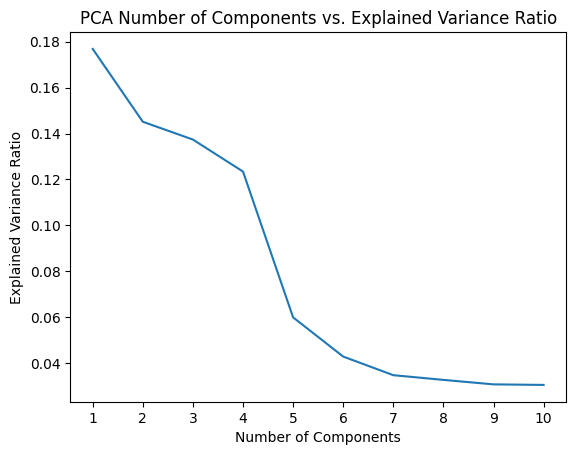

In [ ]:
plt.plot(range(1,11), pca.explained_variance_ratio_)
plt.title('PCA Number of Components vs. Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1,11));

In [ ]:
# we only keep the top 4 abstract features as our transformed categorical features

# process train data
new_cate_feat = PCA(n_components=4).fit_transform(orig_cate_feat)
cate_df = pd.DataFrame({'cate1':new_cate_feat[:,0],'cate2':new_cate_feat[:,1],'cate3':new_cate_feat[:,2],'cate4':new_cate_feat[:,3]})

In [ ]:
# process test data
new_cate_feat20 = PCA(n_components=4).fit_transform(categorical_2020s[selected_feature_chi])
cate_df_20 = pd.DataFrame({'cate1':new_cate_feat20[:,0],'cate2':new_cate_feat20[:,1],'cate3':new_cate_feat20[:,2],'cate4':new_cate_feat20[:,3]})

## Model Building

In [ ]:
# after getting the training data, we split it into training and validation set
from sklearn.model_selection import train_test_split
y = data10s_classification['popular']
X = pd.concat([data10s_classification[selected_features_rf].reset_index(drop=True),cate_df],axis=1)
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
X_test = pd.concat([data20s_classification[selected_features_rf].reset_index(drop=True),cate_df_20],axis=1)
y_test = data20s_classification['popular']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,roc_auc_score, roc_curve,auc

In [ ]:
# define some helper fucntions to print f1 score, recall, precision
def get_val_results(clf):
    return {'f1': f1_score(y_val, clf.predict(X_val)),'precision': precision_score(y_val, clf.predict(X_val)),\
            'recall': recall_score(y_val, clf.predict(X_val))}

def get_test_results(clf):
    return {'f1': f1_score(y_test, clf.predict(X_test)),'precision': precision_score(y_test, clf.predict(X_test)),\
            'recall': recall_score(y_test, clf.predict(X_test))}

def get_train_results(clf):
    return {'f1': f1_score(y_train, clf.predict(X_train)),'precision': precision_score(y_train, clf.predict(X_train)),\
            'recall': recall_score(y_train, clf.predict(X_train))}

### XGBoost
The model tried is XGBoost because it is highly flexible and is suitable for sparse data (our categorical data is sparse)

Main parameters I will consider include:
* n_estimators
* max_depth
* min_child_weight
* gamma
* learning rate

The following code is for tuning the hyperparameter. To save your time when running the code, please go directly to section "Model Evaluation"

Firstly, find the optimal **n_estimators**, which has the largest influence on overfit/underfit

In [ ]:
xgb_cv_p = {'n_estimators':list(range(1,20,1))}
xgb_other_p = {}
clf_xgb = GridSearchCV(XGBClassifier(),xgb_cv_p,cv=5,scoring='f1',return_train_score=True).fit(X_train, y_train)

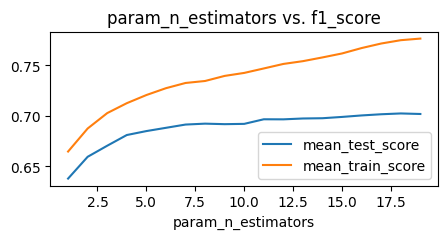

In [ ]:
fig, ax = plt.subplots()
pd.DataFrame(clf_xgb.cv_results_)[['param_n_estimators','mean_test_score']].\
    plot(x='param_n_estimators',y='mean_test_score',figsize=(5,2),title='param_n_estimators vs. f1_score',ax=ax)
pd.DataFrame(clf_xgb.cv_results_)[['param_n_estimators','mean_train_score']].\
    plot(x='param_n_estimators',y='mean_train_score',ax=ax);

From the above plot, we know that after 10, the performance in validation set does not improve significantly, but training performance improved significantly, leading to overfit.

10 would be selected as the best n_estimator to save computatioanl costs and avoid overfitting.


Then we will move on to select **max_depth**

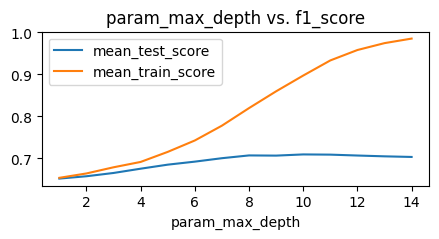

In [ ]:
xgb_cv_p = {'max_depth':list(range(1,15))}
xgb_other_p = {'n_estimators':10}
clf_xgb = GridSearchCV(XGBClassifier(**xgb_other_p),xgb_cv_p,cv=5,scoring='f1',return_train_score=True).fit(X_train, y_train)

fig, ax = plt.subplots()
pd.DataFrame(clf_xgb.cv_results_)[['param_max_depth','mean_test_score']].\
    plot(x='param_max_depth',y='mean_test_score',figsize=(5,2),title='param_max_depth vs. f1_score', ax=ax)
pd.DataFrame(clf_xgb.cv_results_)[['param_max_depth','mean_train_score']].\
    plot(x='param_max_depth',y='mean_train_score',figsize=(5,2),ax=ax);

The model is highly sensitive at max_depth. With max_depth over 4, the model starts to overfit. Thus, we set max_depth at 4 to keep it as simple as possible

Then, we move on to tune **min_child_weight**

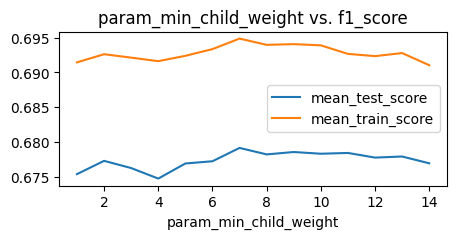

In [ ]:
xgb_cv_p = {'min_child_weight':list(range(1,15))}
xgb_other_p = {'max_depth':4, 'n_estimators':10}
clf_xgb = GridSearchCV(XGBClassifier(**xgb_other_p),xgb_cv_p,cv=5,scoring='f1',return_train_score=True).fit(X_train, y_train)

fig,ax = plt.subplots()
pd.DataFrame(clf_xgb.cv_results_)[['param_min_child_weight','mean_test_score']].\
    plot(x='param_min_child_weight',y='mean_test_score',figsize=(5,2),title='param_min_child_weight vs. f1_score',ax=ax)
pd.DataFrame(clf_xgb.cv_results_)[['param_min_child_weight','mean_train_score']].\
    plot(x='param_min_child_weight',y='mean_train_score',ax=ax);

Setting min_child_weight at 7 would slightly boost the performance

We move on to **gamma** to consider regularization

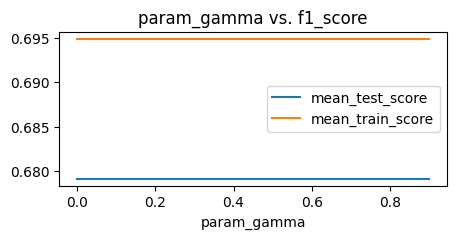

In [ ]:
xgb_cv_p = {'gamma':np.arange(0,1,0.1)}
xgb_other_p = {'max_depth':4, 'n_estimators':10, 'min_child_weight': 7}
clf_xgb = GridSearchCV(XGBClassifier(**xgb_other_p),xgb_cv_p,cv=5,scoring='f1',return_train_score=True).fit(X_train, y_train)

fig,ax = plt.subplots()
pd.DataFrame(clf_xgb.cv_results_)[['param_gamma','mean_test_score']].\
    plot(x='param_gamma',y='mean_test_score',figsize=(5,2),title='param_gamma vs. f1_score',ax=ax)
pd.DataFrame(clf_xgb.cv_results_)[['param_gamma','mean_train_score']].\
    plot(x='param_gamma',y='mean_train_score',ax=ax);

Changing gamma does not improve the performance compared with the default value. We will keep the default value


Finally, we will look into **learning rate**.


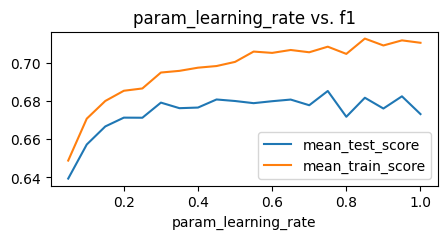

In [ ]:
xgb_cv_p = {'learning_rate': np.arange(0.05,1.05,0.05)}
xgb_other_p = {'max_depth':4, 'n_estimators':10, 'min_child_weight': 7}
clf_xgb = GridSearchCV(XGBClassifier(**xgb_other_p),xgb_cv_p,cv=5,scoring='f1',return_train_score=True).fit(X_train, y_train)

fig,ax = plt.subplots()
pd.DataFrame(clf_xgb.cv_results_)[['param_learning_rate','mean_test_score']].\
    plot(x='param_learning_rate',y='mean_test_score',figsize=(5,2),title='param_learning_rate vs. f1', ax=ax)
pd.DataFrame(clf_xgb.cv_results_)[['param_learning_rate','mean_train_score']].\
    plot(x='param_learning_rate',y='mean_train_score', ax=ax);

With a learnin rate at around 0.4, we achieved a relatively ideal and stable performance

In [ ]:
# build our model based on the best parameters we chose
xgb_other_p = {'max_depth':4, 'n_estimators':10, 'min_child_weight': 7, 'learning_rate':0.4}
xgb = XGBClassifier(**xgb_other_p).fit(X_train, y_train)

In [ ]:
# save model for future use
xgb.save_model('02.json')

### Model Evaluation

In [ ]:
xgb = XGBClassifier()  # init model
xgb.load_model('02.json')  # load the model

The following figure shows the predicted probability of a song that may be popular in validation set and training set. From the distribution, there is no clear seperate of high probability and low probability


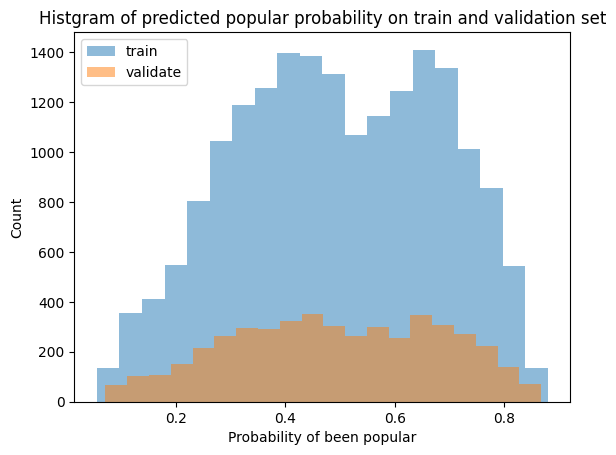

In [ ]:
plt.hist(xgb.predict_proba(X_train)[:,1],bins=20,alpha=0.5,label='train')
plt.hist(xgb.predict_proba(X_val)[:,1],bins=20,alpha=0.5,label='validate')
plt.xlabel('Probability of been popular')
plt.ylabel('Count')
plt.title('Histgram of predicted popular probability on train and validation set')
plt.legend()
plt.show()

In [ ]:
# calculate the evaluation metrics for the model in training and validation set
train_d = get_train_results(xgb)
val_d = get_val_results(xgb)
pd.concat([pd.DataFrame(train_d,index=['Train']), pd.DataFrame(val_d,index=['Validate'])])


,f1,precision,recall
Train,0.682415,0.687742,0.677170
Validate,0.665045,0.674439,0.655909


### Test on 2020s Data

The following histgram demonstrates the distribution of predicted probability on test set. As the prediction resembles normal distribution with a slight skew to left, it implies that the predictive model may not generalize well in future data

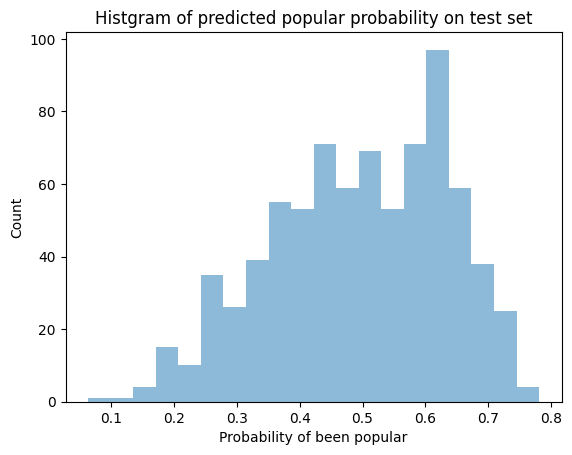

In [ ]:
plt.hist(xgb.predict_proba(X_test)[:,1],bins=20,alpha=0.5)
plt.xlabel('Probability of been popular')
plt.ylabel('Count')
plt.title('Histgram of predicted popular probability on test set')
plt.show()

In [ ]:
# Metrices on testing data
pd.DataFrame(get_test_results(xgb),index=['Test'])

,f1,precision,recall
Test,0.561856,0.543641,0.581333


## Limitation and Future Work

As we have shown, the model does not perform well in testing data, when the decades are different. This may due to the unexpected change in music taste over time. The following shows that the correlation between different features to the popularity varies a lot over different year.

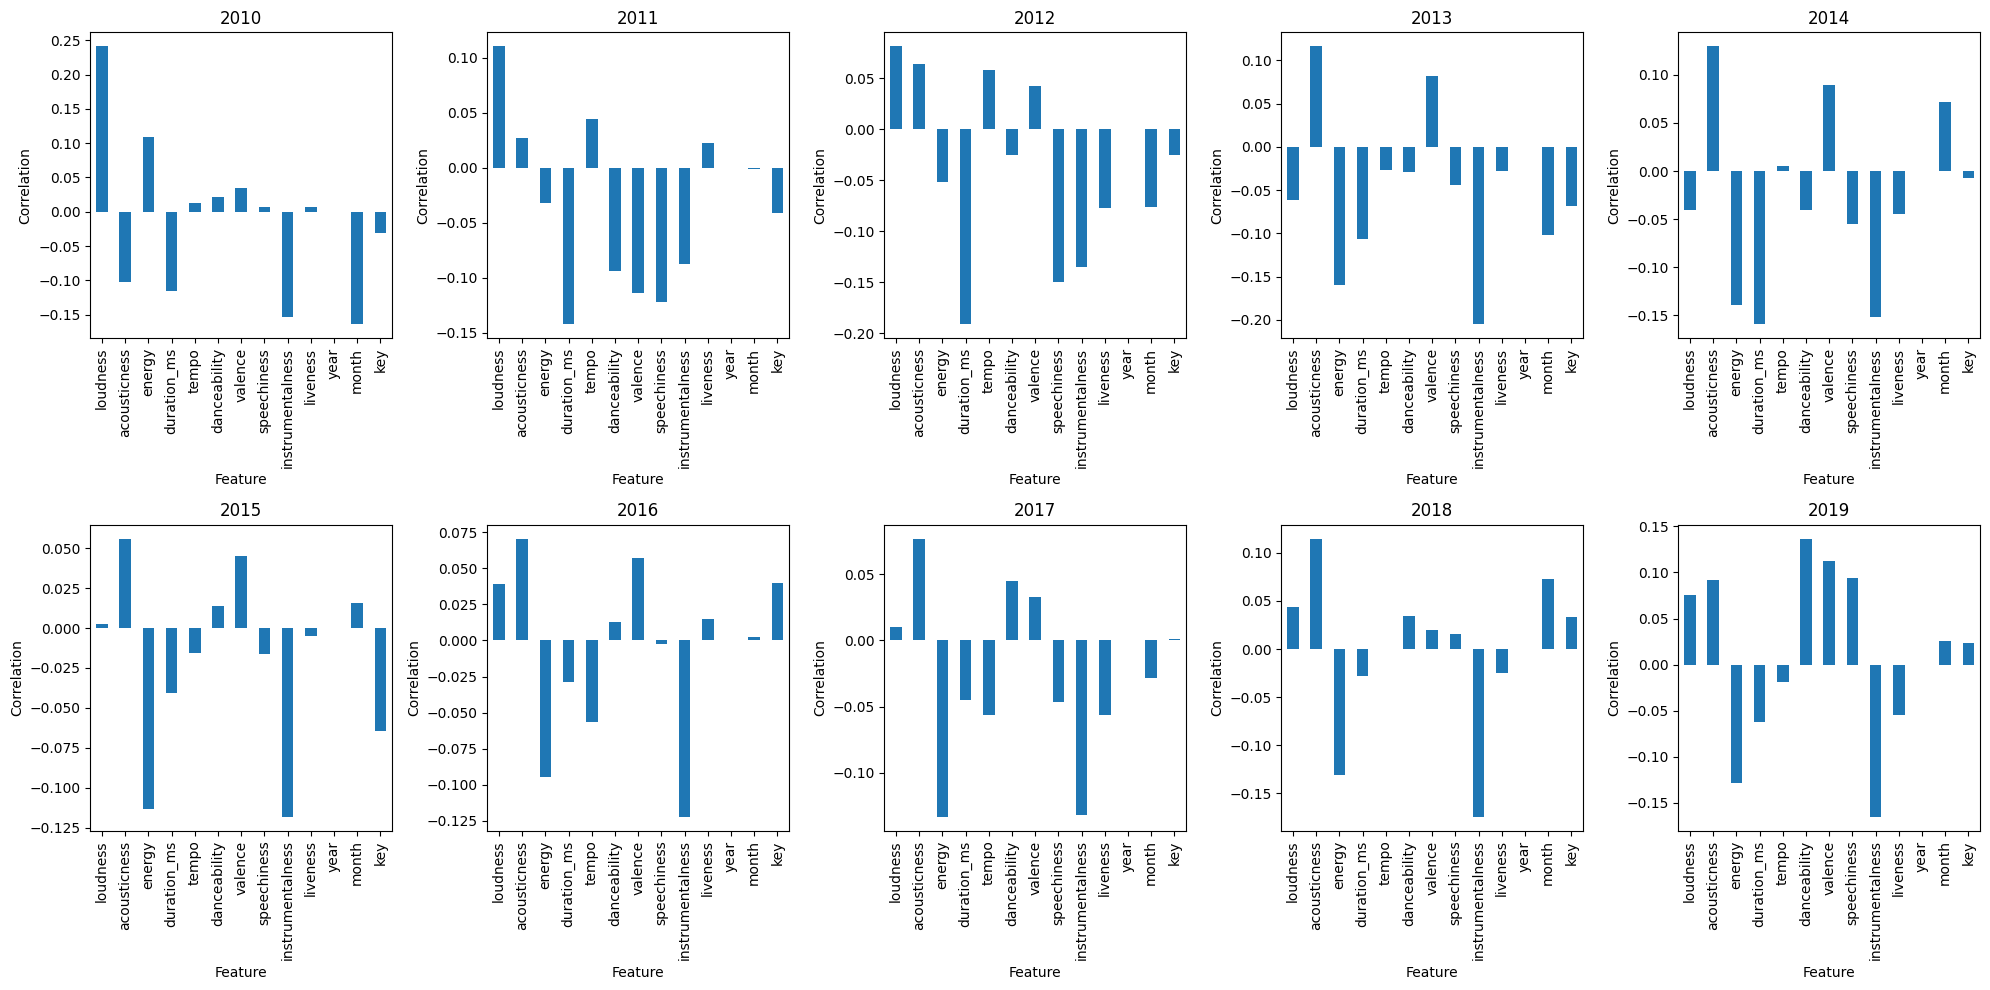

In [ ]:
filter_data = pd.concat([X.reset_index(drop=True,inplace=False),y.reset_index(drop=True,inplace=False)],axis=1)
years = filter_data.year.unique()
fig, ax = plt.subplots(2,5,figsize=(20,10))
for year in years:
  filter_data[filter_data.year==year].corr()['popular'][:-5].plot(kind='bar',ax=ax[(year-2010)//5][(year-2010)%5])
  ax[(year-2010)//5][(year-2010)%5].set_title(year)
  ax[(year-2010)//5][(year-2010)%5].set_xlabel('Feature')
  ax[(year-2010)//5][(year-2010)%5].set_ylabel('Correlation')
plt.tight_layout()

To better predict music popularity, more data in most recent period is needed